In [1]:
import joblib as jb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap, MarkerCluster
import seaborn as sns
import math
import eli5
import sklearn
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from folium.plugins import HeatMap, MarkerCluster
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from geopy.geocoders import Nominatim
import warnings
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
warnings.filterwarnings('ignore')


%matplotlib inline

In [2]:
delhi=pd.read_csv("Delhi_v2.csv")
delhi.drop(columns='Unnamed: 0',inplace=True)
delhi.describe()

price         area     latitude    longitude     Bedrooms  \
count  7.738000e+03  7738.000000  7738.000000  7738.000000  7738.000000   
mean   8.320635e+06  1409.506591    28.552092    77.273476     2.708193   
std    7.223197e+06   718.929581     0.107420     0.180606     0.877026   
min    1.700000e+06   501.000000    28.240023    76.884101     2.000000   
25%    4.200000e+06   990.000000    28.455539    77.078590     2.000000   
50%    6.000000e+06  1250.000000    28.574637    77.345320     3.000000   
75%    9.500000e+06  1650.000000    28.642520    77.421054     3.000000   
max    8.500000e+07  9500.000000    28.799748    77.688028    10.000000   

         Bathrooms      Balcony      parking         Lift    Price_sqft  
count  7738.000000  5166.000000  2612.000000  1733.000000   7738.000000  
mean      2.501163     2.426442     7.673047     1.829198   5543.660241  
std       0.867050     1.083677    60.417508     1.192607   2408.659307  
min       2.000000     1.000000     1.000000     0.000000   2100.000000  
25%       2.000000     2.000000     1.000000     1.000000   3950.986915  
50%       2.000000     2.000000     1.000000     2.000000   4972.674332  
75%       3.000000     3.000000     2.000000     2.000000   6350.638693  
max      10.000000    10.000000  1406.000000    10.000000  44378.698225

In [3]:
delhi.dtypes

price               float64
Address              object
area                float64
latitude            float64
longitude           float64
Bedrooms            float64
Bathrooms           float64
Balcony             float64
Status               object
neworold             object
parking             float64
Furnished_status     object
Lift                float64
Landmarks            object
type_of_building     object
desc                 object
Price_sqft          float64
dtype: object

In [4]:
for i in delhi.columns[delhi.dtypes==object]:
    print("\n",i,"\n")
    print(delhi[i].unique())
    print(delhi[i].value_counts())


 Address 

['Noida Extension, Noida, Delhi NCR' 'Sector 79, Gurgaon, Delhi NCR'
 'Vaishali, Ghaziabad, Delhi NCR' ...
 'Sector137 Noida Paramount Floraville, Sector 137, Noida, Delhi NCR'
 'Greater Noida, Sector 2, Greater Noida, Delhi NCR'
 'sandal apartment, Shalimar Garden Extension 1, Ghaziabad, Delhi NCR']
Raj Nagar Extension, Ghaziabad, Delhi NCR                                     163
Indirapuram, Ghaziabad, Delhi NCR                                             152
Greater Noida West, Greater Noida, Delhi NCR                                  100
Noida Extension, Noida, Delhi NCR                                              63
NH 24, Ghaziabad, Delhi NCR                                                    61
                                                                             ... 
e block sector 57, Sector 57, Gurgaon, Delhi NCR                                1
Ramakrishna apartment, Indraprastha Extension, New Delhi - East, Delhi NCR      1
Rajnagar Extension Gahziabad, 

In [5]:
def editing(data):
    l=[]
    data=data[data.Price_sqft<75000]
    data.drop(columns=["Address","Status","desc","Price_sqft"],inplace=True)
    data.neworold.replace(["Resale","New Property",'Other\n\t\t\t\t\t\t\t\t\tGet Documents Verified'],[0,1,0],inplace=True)
    data.type_of_building.replace(["Flat","Individual House"],[0,1],inplace=True)
    data.Furnished_status.replace(['Semi-Furnished', 'Unfurnished', 'Furnished'],[1,0,2],inplace=True)
    for i in data.Landmarks:
        if type(i)==str:
            l.append(1)
        else:
            l.append(0)     
    data.Landmarks=l
    data.replace(np.nan,0,inplace=True)
    l=[]
    for i in data.Lift:
        if i>0:
            l.append(1)
        else:
            l.append(0)
    data.Lift=l
    l=[]        
    for i in data.parking:
        if i>0:
            l.append(1)
        else:
            l.append(0)        
    data.parking=l
    data.price=data.price/1000000
    data=data[data.price<100]
    data=data[data.price>1]
    return data  
delhi=editing(delhi)

In [6]:
sns.set_style("whitegrid")
def map_func(data):
    map_data=data[['latitude','longitude','price']]
    city_map = folium.Map(location=[data.latitude.mean(),data.longitude.mean()], zoom_start=9.5, tiles='openstreetmap')
    mc = MarkerCluster()
    for idx, row in map_data.iterrows():
        popup = """
        Price : <b>%s</b><br>
        """ % ( row['price'])
        mc.add_child(folium.Marker([row['latitude'], row['longitude']],tooltip=popup))
        city_map.add_child(mc)
    return city_map
map_func(delhi)

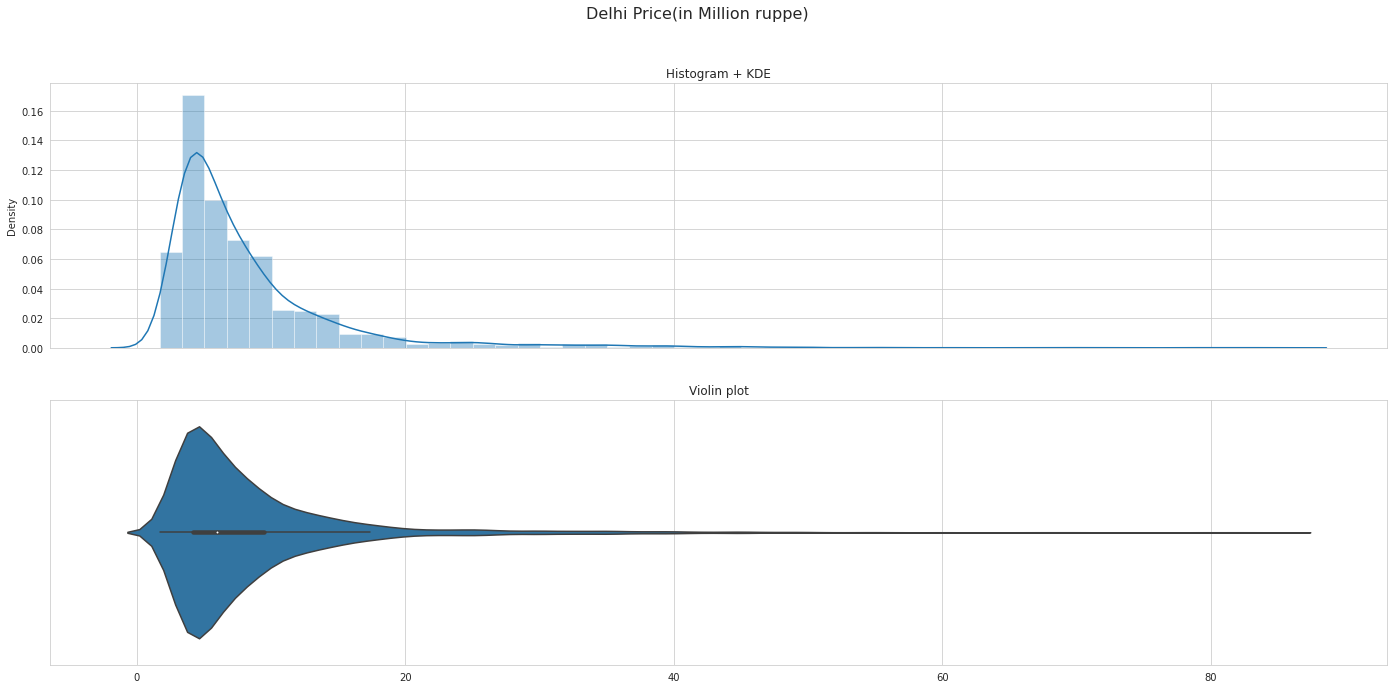

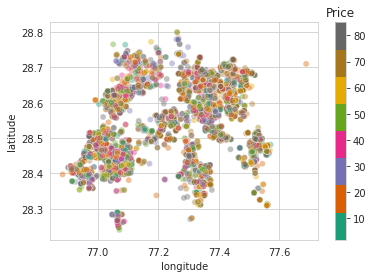

In [7]:
def kdehist(data, title):
    x=data.price
    fig, ax = plt.subplots(2,1,figsize=(20,10),sharex=True)
    sns.distplot(x, ax=ax[0])
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.violinplot(x, ax=ax[1])
    ax[1].set(xlabel=None)
    ax[1].set_title('Violin plot')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(pad=3.0)
    plt.show()
    norm = plt.Normalize(x.min(), x.max())
    sm = plt.cm.ScalarMappable(cmap="Dark2", norm=norm)
    sm.set_array([])
    ax=sns.scatterplot(x="longitude",y="latitude",data=data, alpha=0.4 ,cmap=plt.get_cmap("Dark2"),hue="price",palette="Dark2")
    ax.get_legend().remove()
    s=ax.figure.colorbar(sm)
    s.ax.set_title("Price")
kdehist(delhi,"Delhi Price(in Million ruppe)")    

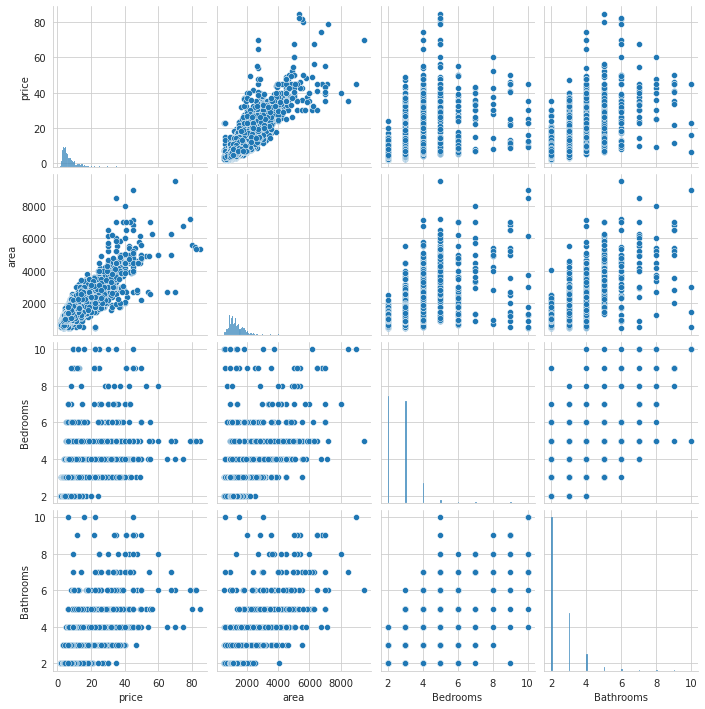

In [8]:
l=['price', 'area', 'Bedrooms', 'Bathrooms']
sns.pairplot(delhi[l])

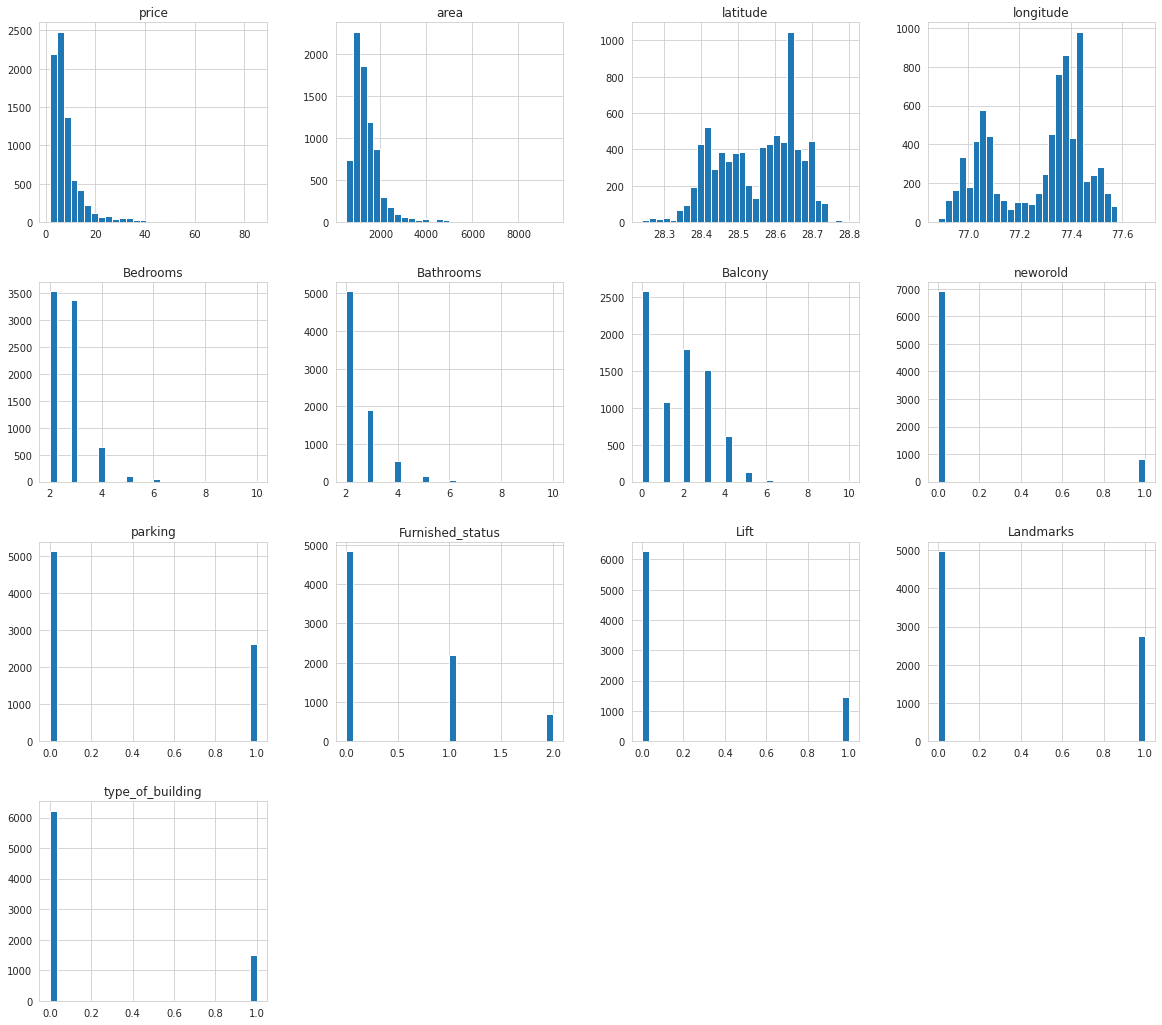

In [9]:
delhi.hist(bins=30,figsize=(20,18))
plt.show()

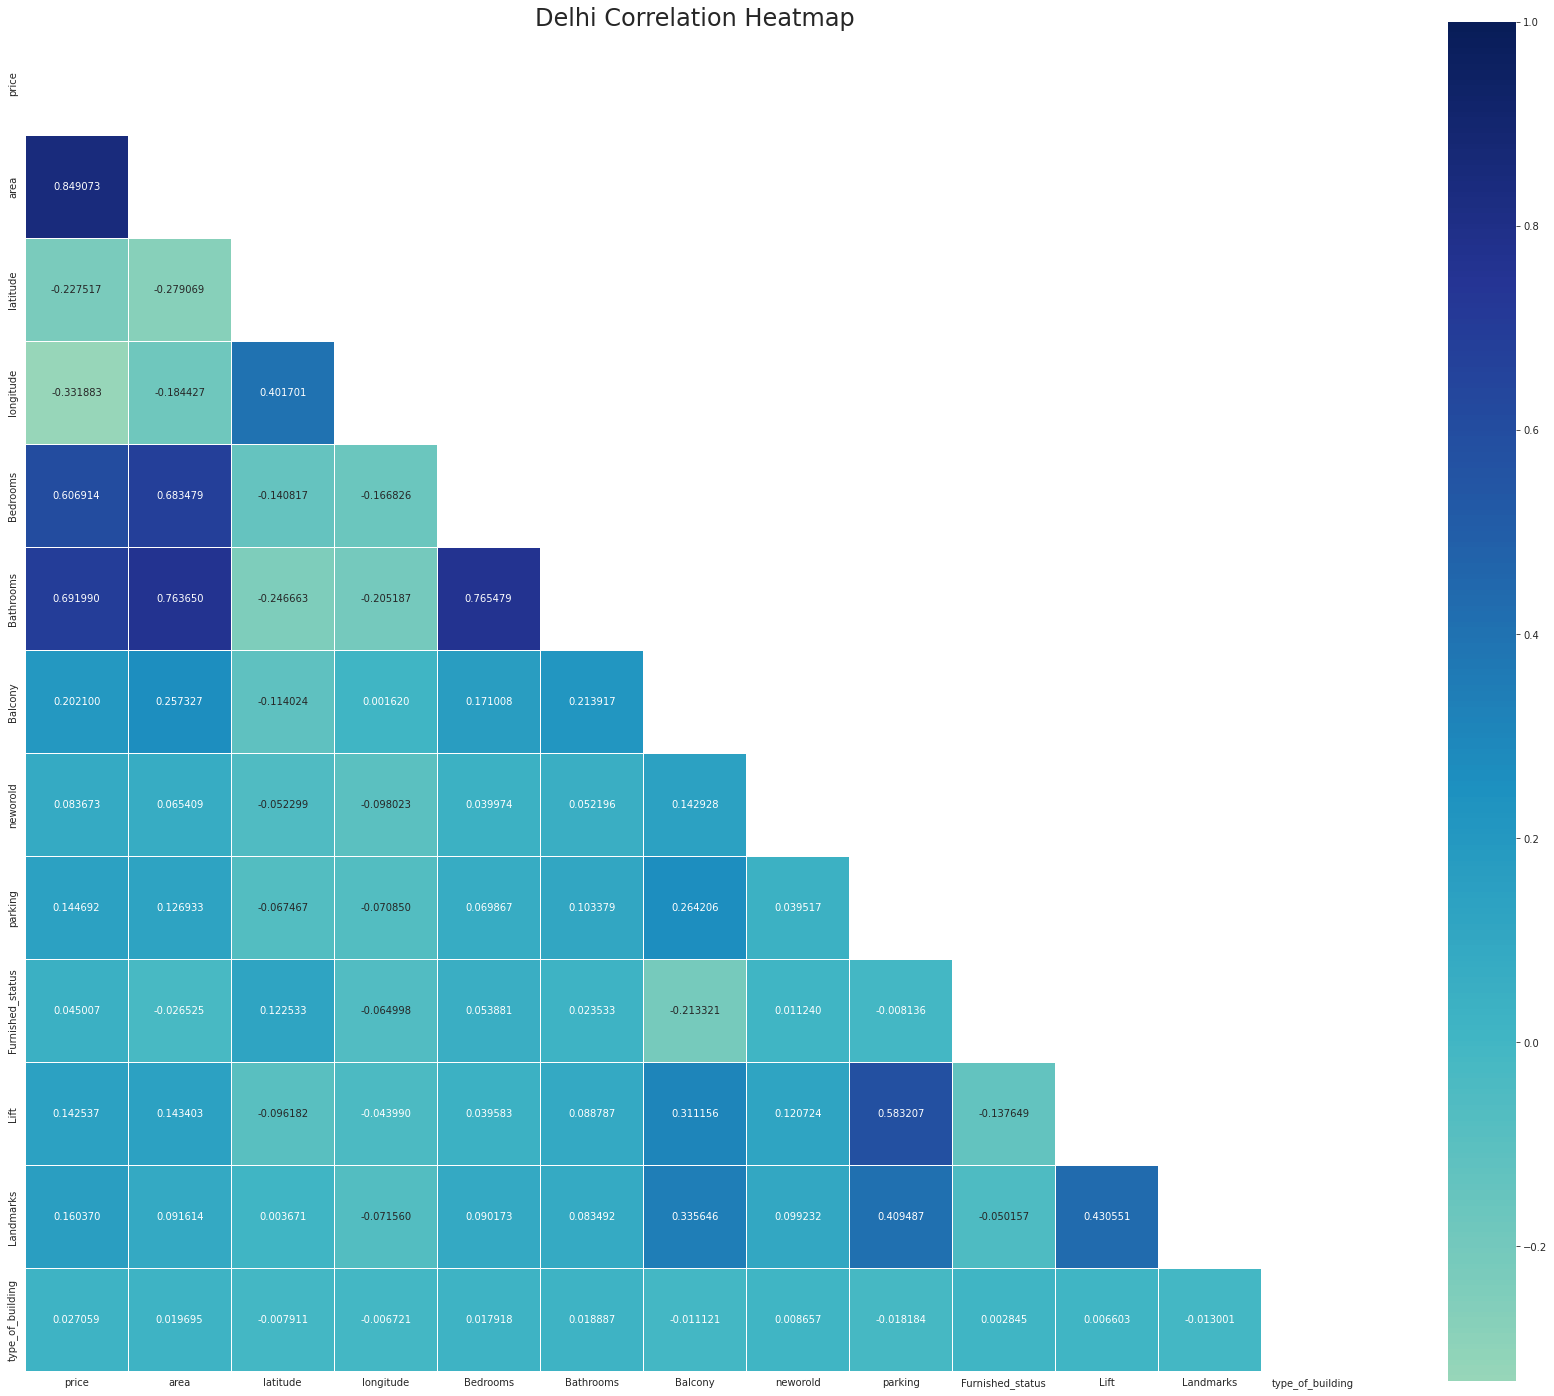

In [10]:
def corr_func(data,title):
    plt.figure(figsize=(30,25))
    corr_matrix=data.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    fig=sns.heatmap(data.corr(),mask=mask, cmap="YlGnBu", vmax=1, center=0, fmt="f",square=True, linewidths=.5,annot=True)
    plt.title(title, fontsize=24)
    plt.show()
corr_func(delhi,"Delhi Correlation Heatmap")

In [11]:
train=delhi[:7000]
test=delhi[7000:]

In [12]:
def preprocess(data):
    try:
        data.price=np.log2(data.price)
        data.area=np.log2(data.area)
        data["new"]=data.latitude*data.longitude
        data["new2"]=data.Bedrooms*delhi.Bathrooms
        data=data.drop(columns='longitude')
    except:
        pass
    return data

In [13]:
transformer = FunctionTransformer(preprocess)
pipeline = make_pipeline(transformer,RandomForestRegressor(n_jobs=-1, random_state=42,max_features=12,min_samples_leaf=1))
pipeline.fit(train.drop(columns='price'),train['price'])
predicted=pipeline.predict(test.drop(columns='price'))

In [14]:
r2_score(test.price,predicted)

0.9201566979066178

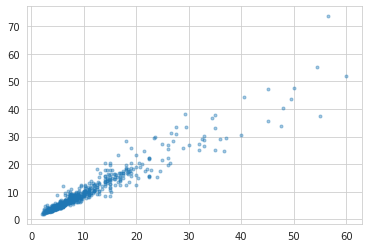

In [15]:
plt.scatter(test.price,predicted,alpha=0.4,marker=".")
plt.show()